# Oscillations in a ring network
A study investigating the effect of mean-free noise on the frequency.
Usage of the Brian2 library.

In [1]:
from brian2 import NeuronGroup, Synapses, StateMonitor, run, defaultclock, ms, second, TimedArray, seed, start_scope, plot, figure, rand
import matplotlib.pyplot as plt
import numpy as np


def monitor_neurons(*pops):
    return [StateMonitor(pop, ["F", "rate", "inh_input"], record=True, dt=1*defaultclock.dt) for pop in pops]

def plot_traces(statemonitor):
    for monitor in (statemonitor.F, statemonitor.rate, statemonitor.inh_input):
        #
        plt.figure(figsize=(12, 4))
        plt.plot(statemonitor.t, monitor[0])
        plt.plot(statemonitor.t, monitor.T)
        plt.xlabel("time [s]")
        plt.ylabel("amplitude [au]")
        #plot(statemonitor.t, monitor.T)
        
def visualise_connectivity(S, figsize:float=(10, 4)):
    """From brian2 tutorials."""
    Ns = len(S.source)
    Nt = len(S.target)
    plt.figure(figsize=figsize)
    plt.subplot(121)
    plt.plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plt.plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plt.plot([0, 1], [i, j], '-k')
    plt.xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1, max(Ns, Nt))
    plt.subplot(122)
    plt.plot(S.i, S.j, 'ok')
    plt.xlim(-1, Ns)
    plt.ylim(-1, Nt)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

In [2]:
# Same as before, but the rate is clipped between 0 and 1000 (in case the noise is added for the output rate instead of the input)
def eqs(tau:str, gwn_var:str):
    """
    Equations for a rate model with signmoidal transfer function (dF/dt)
    syn_input as sum of exc. and inh. input.
    ext input as mean free noise
                      F = F_max/(1+exp(beta*(epsilon-u))) : 1
    """
    return f"""
        dF/dt = -F / ({tau}) +  F_max / (1 + exp( -beta * (syn_input + ext_input - F_0))) / ({tau}) :  1
        rate = clip(F, 0, 1) : 1
        syn_input = -inh_input : 1
        exc_input : 1
        inh_input : 1
        ext_input = {gwn_var}(t, i) : 1
    """


def syn_eqs(var:str):
    eqs = f"""
        w : 1
        {var}_post = w * rate_pre : 1 (summed)
      """
    return eqs

In [3]:
def create_neuronal_populations():
    neurons_exc = NeuronGroup(N, eqs(tau_exc, "gwn_exc"), method = "euler")
    neurons_inh = NeuronGroup(N, eqs(tau_inh, "gwn_inh"), method = "euler")
    for neurons in (neurons_exc, neurons_inh):
        neurons.F = np.random.uniform(size=N)
    return neurons_exc, neurons_inh

def connect_forward(pre, post, is_excitatory:bool=True):
    input_type = "exc_input" if is_excitatory else "inh_input"
    syn = Synapses(pre, post, syn_eqs(input_type), method="euler")
    syn.connect(j=f'k%{N} for k in range(i, i+FF+1) if i!=k')
    return syn

def connect_backward(pre, post, is_inhibitory:bool=True):
    input_type = "inh_input" if is_inhibitory else "exc_input"
    syn = Synapses(pre, post, syn_eqs(input_type), method="euler")
    syn.connect(j=f'k%{N} for k in range(i-FB, i) if i!=k')
    return syn

In [4]:
def simulate(connect:bool, visualize:bool=False):
    start_scope()

    # noise is applied also during stimulation
    neurons_exc, neurons_inh = create_neuronal_populations()
    statemon_neurons_exc, statemon_neurons_inh = monitor_neurons(neurons_exc, neurons_inh)

    if connect:
        """
        syn_IE = connect_forward(neurons_exc, neurons_inh)
        syn_IE.w = weight
        syn_EE = connect_forward(neurons_exc, neurons_exc)
        syn_EE.w = weight
        
        syn_EI = connect_backward(neurons_inh, neurons_exc)
        syn_EI.w = weight * g
        """
        syn_II = connect_backward(neurons_inh, neurons_inh)
        syn_II.w = weight * g
        if visualize:
            visualise_connectivity(syn_II)
        
        """
        for syn in (syn_IE, syn_EE, syn_EI, syn_II):
            visualise_connectivity(syn)
        """
    run(t_sim)
    return statemon_neurons_exc, statemon_neurons_inh

# Parameter definition


In [5]:
N = 5
tau_sigma = .01*ms
tau_exc = "20*ms"
tau_inh = "20*ms"
    
defaultclock.dt = 1.*ms
t_sim = 5*second

# Transfer funtion (sigmoidal activation)
beta = 5.
F_0 = -2
F_max = 1

# external noise
ext_mu = 0.
sigma = 0
#sigma = 1

gwn_exc = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)

# Synaptic strength {weight} and the inh. counterpart {g}*{weight}
weight = 1
g = 5

# Projections - How many forward and how many backwards connections
FF = 0
FB = 1

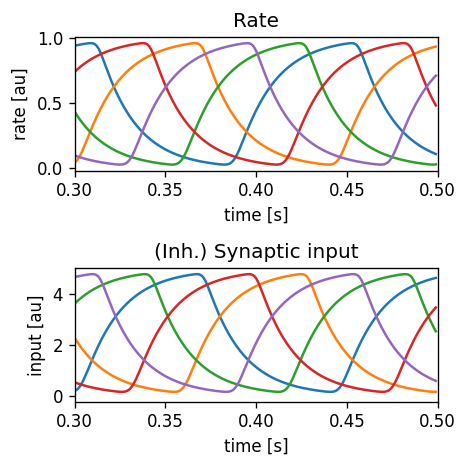

In [6]:
# Plot 2 rate figures with and without noise
t_sim_temp = t_sim
t_sim = 500*ms
_, statemon_neurons_inh = simulate(connect=True)

fig, axes = plt.subplots(2, 1, num="rate_and_input", figsize=(4, 4), dpi=120)
ax = axes[0]
for monitor in statemon_neurons_inh.rate:
    ax.plot(statemon_neurons_inh.t, monitor)
ax.set_title("Rate")
ax.set_xlabel("time [s]")
ax.set_ylabel("rate [au]")
ax.set_xlim(300*ms, 500*ms)

ax = axes[1]
for monitor in statemon_neurons_inh.inh_input:
    ax.plot(statemon_neurons_inh.t, monitor)
ax.set_title("(Inh.) Synaptic input")
ax.set_xlabel("time [s]")
ax.set_ylabel("input [au]")
ax.set_xlim(300*ms, 500*ms)
fig.tight_layout()
fig.savefig("rate_and_input.svg")


t_sim = t_sim_temp

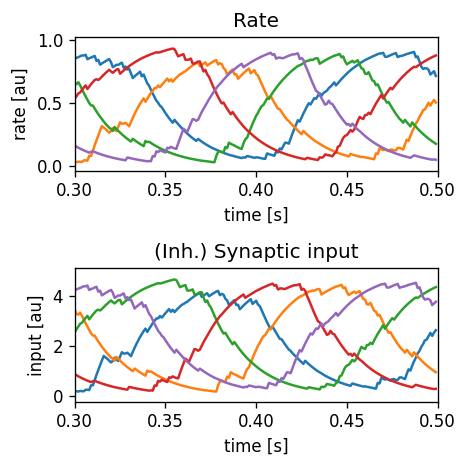

In [7]:
# Plot 2 rate figures with and without noise
t_sim_temp = t_sim
t_sim = 500*ms
gwn_inh_temp = gwn_inh
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=1, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
_, statemon_neurons_inh = simulate(connect=True)

fig, axes = plt.subplots(2, 1, num="rate_and_input_noise", figsize=(4, 4), dpi=120)
ax = axes[0]
for monitor in statemon_neurons_inh.rate:
    ax.plot(statemon_neurons_inh.t, monitor)
ax.set_title("Rate")
ax.set_xlabel("time [s]")
ax.set_ylabel("rate [au]")
ax.set_xlim(300*ms, 500*ms)

ax = axes[1]
for monitor in statemon_neurons_inh.inh_input:
    ax.plot(statemon_neurons_inh.t, monitor)
ax.set_title("(Inh.) Synaptic input")
ax.set_xlabel("time [s]")
ax.set_ylabel("input [au]")
ax.set_xlim(300*ms, 500*ms)
fig.tight_layout()
#fig.savefig("rate_and_input_noise.svg")


t_sim = t_sim_temp
gwn_inh = gwn_inh_temp

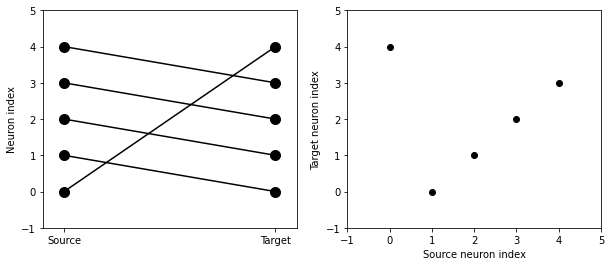

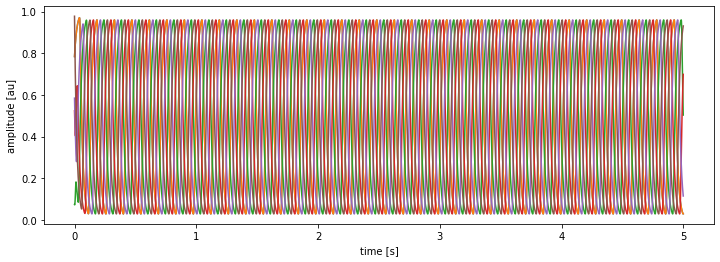

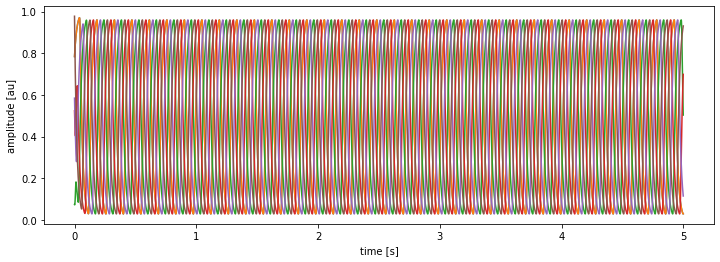

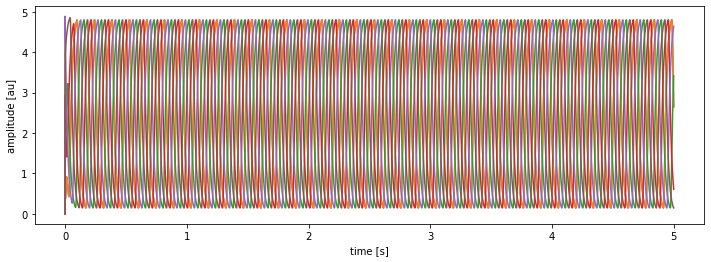

In [8]:
statemon_neurons_exc, statemon_neurons_inh = simulate(connect=True, visualize=True)
#plot_traces(statemon_neurons_exc)
plot_traces(statemon_neurons_inh)

# Analysis

In [9]:
import scipy.signal as SCS
from scipy import fft
from brian2 import Hz

def power(s:np.ndarray, dt:float)->tuple:
    p = fft.rfft(s, norm="forward")
    p[0] = 0 # Removing DC
    p = 2 * np.abs(p) # Normalize by factor 2 to account for +freq and - freq
    freq = fft.rfftfreq(len(s), d=dt)
    
    peak_power, power_f, ratio = find_power_peak(p, freq)
    return p, freq, peak_power, power_f, ratio

def find_power_peak(p:np.ndarray, freq:np.ndarray):
    peak_power_idx = np.argmax(p, axis=-1)
    peak_power = np.max(p, axis=-1) 
    power_f = freq[peak_power_idx]
    
    ratio = peak_power / p.sum(axis=-1)
    return peak_power, power_f, ratio


warmup = 100*ms
def analyze_spectrum(monitors, warmup:float=100*ms, plot:bool=False):
    power_spectra = []
    # Skip warmup time
    for neuron in monitors.rate[:, monitors.t > warmup]:
        p, freq, peak_power, power_f, ratio = power(neuron, defaultclock.dt)
        power_spectra.append(p)
        print(peak_power, power_f, ratio)
    power_spectra = np.asarray(power_spectra)

    peak_power, power_f, ratio = find_power_peak(power_spectra, freq)
    peak_power_merge, power_f_merge, ratio_merge = find_power_peak(power_spectra.mean(axis=0), freq)
    print("Averaged:", peak_power_merge, power_f_merge, ratio_merge)
    
    if plot:
        plt.figure()
        #plt.scatter(power_f, peak_power)
        #plt.scatter(power_f_merge, peak_power_merge, c="k")
        for p in power_spectra:
            plt.plot(freq, p)
        plt.plot(freq, power_spectra.mean(axis=0), "k")
        plt.xlim(0, 10)
        plt.ylabel("amplitude")
        plt.xlabel("frequency [Hz]")
    return freq, power_spectra

In [10]:
# Noise-free
F_0 = -2
sigma = 0.0
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
_, noise_free_monitor = simulate(connect=True)
freq, noise_free_power = analyze_spectrum(noise_free_monitor)

0.46919586354547693 6.94019188 Hz 0.3092037632058996
0.4695585368267096 6.94019188 Hz 0.33717187612418514
0.4702556559621959 6.94019188 Hz 0.345171927337672
0.4700534959364648 6.94019188 Hz 0.34515395925409664
0.46910247979534453 6.94019188 Hz 0.2825901170418666
Averaged: 0.46963320641323836 6.94019188 Hz 0.32191668730840467


In [11]:
# saturation
F_0 = -4
sigma = 0.0
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
_, saturation_monitor = simulate(connect=True)
freq, saturation_power = analyze_spectrum(saturation_monitor)

0.44412910144346246 5.51132884 Hz 0.16496224581056795
0.445125741194214 5.51132884 Hz 0.21133828559491633
0.4485273422880895 5.51132884 Hz 0.21120162656930708
0.44658062181788954 5.51132884 Hz 0.2328662983151629
0.4451918187114322 5.51132884 Hz 0.16686432115090732
Averaged: 0.4459109250910176 5.51132884 Hz 0.1937401048800248


In [12]:
# Noise
F_0 = -2
sigma = .99
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
_, noise_monitor = simulate(connect=True)
freq, noise_power = analyze_spectrum(noise_monitor)

0.35611632682168864 6.12369871 Hz 0.14192754180572292
0.349782392345111 6.12369871 Hz 0.13914152475043126
0.35140352786283 6.12369871 Hz 0.13914385269710003
0.3489504975787397 6.12369871 Hz 0.13572637639168367
0.35225479708647256 6.12369871 Hz 0.13936770811483346
Averaged: 0.35170150833896835 6.12369871 Hz 0.13904567406149232


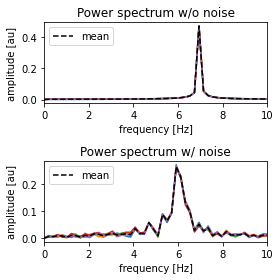

In [104]:
fig, axes = plt.subplots(2, 1, num="powerspectra", figsize=(4, 4))

for ax, powers in zip(axes, (noise_free_power, noise_power)):
    for p in powers:
        ax.plot(freq, p)
    ax.plot(freq, powers.mean(axis=0), "k", ls="--", label="mean")
    ax.set_xlim(0, 10)
    ax.set_ylabel("amplitude [au]")
    ax.set_xlabel("frequency [Hz]")
    ax.legend(loc="upper left")
ax = axes[0]
ax.set_title("Power spectrum w/o noise")
ax = axes[1]
ax.set_title("Power spectrum w/ noise")
fig.tight_layout()
fig.savefig("spectra.svg")

0.4698799263937512 6.94019188 Hz 0.3452600840653521
0.47039943915155885 6.94019188 Hz 0.34316175816602557
0.46938936469355996 6.94019188 Hz 0.28072437514455756
0.46902152826582705 6.94019188 Hz 0.3126175335362709
0.4696810021889056 6.94019188 Hz 0.33094929109217275
Averaged: 0.4696742521387206 6.94019188 Hz 0.3206717045537509
0.38791024027959153 6.12369871 Hz 0.16515542356848992
0.38494590889927993 6.12369871 Hz 0.14461640480818125
0.38278737277158253 6.12369871 Hz 0.13071230693720778
0.3836973094282655 6.12369871 Hz 0.1268000213735456
0.3860115739911491 6.12369871 Hz 0.16090852227355182
Averaged: 0.3850704810739737 6.12369871 Hz 0.14406978641926144
0.2724863503118005 6.12369871 Hz 0.09161109760768742
0.27387078523999364 6.12369871 Hz 0.09348019254909012
0.2705775160147465 6.12369871 Hz 0.09834792755791166
0.2744569792273217 6.12369871 Hz 0.09738142845986436
0.27639115758365074 6.12369871 Hz 0.09293479531166436
Averaged: 0.27355655767550263 6.12369871 Hz 0.09467110223104863


(array([0.00000000e+00, 2.04123290e-01, 4.08246581e-01, ...,
        4.99489692e+02, 4.99693815e+02, 4.99897938e+02]) * hertz,
 array([[0.00000000e+00, 9.14472477e-03, 7.30263365e-03, ...,
         1.52569807e-04, 6.04598839e-05, 4.01101180e-05],
        [0.00000000e+00, 1.07345515e-02, 5.08917366e-03, ...,
         2.62901008e-04, 2.63358867e-04, 2.50759419e-04],
        [0.00000000e+00, 1.38977270e-02, 3.89224954e-03, ...,
         3.47006482e-04, 2.55045683e-04, 3.00580389e-04],
        [0.00000000e+00, 1.18040937e-02, 8.62163262e-04, ...,
         1.53484655e-04, 1.51834850e-04, 1.65125353e-04],
        [0.00000000e+00, 9.62407335e-03, 7.59658627e-03, ...,
         1.70745772e-04, 1.00772974e-05, 2.96817927e-04]]))

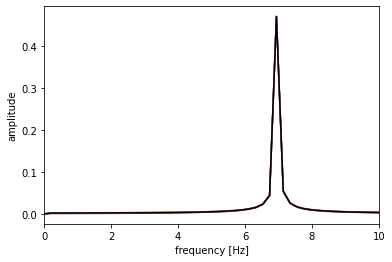

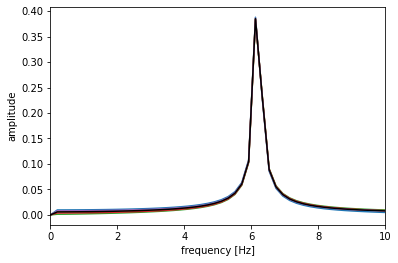

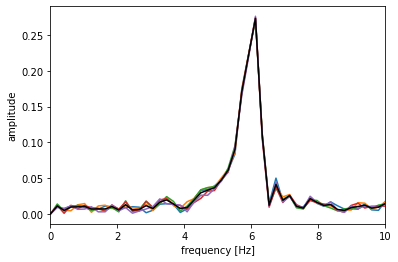

In [118]:
F_0 = -2
sigma = 0.0
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
_, statemon_neurons_inh = simulate(connect=True)
analyze_spectrum(statemon_neurons_inh, plot=True)
F_0 = -1.4
_, statemon_neurons_inh = simulate(connect=True)
analyze_spectrum(statemon_neurons_inh, plot=True)
F_0 = -2
sigma = 1.0
gwn_inh = TimedArray(np.random.normal(loc=ext_mu, scale=sigma, size=(int(t_sim/defaultclock.dt), N)), dt=defaultclock.dt)
_, statemon_neurons_inh = simulate(connect=True)
analyze_spectrum(statemon_neurons_inh, plot=True)
